## Libraries

In [49]:
import pandas as pd
import os
import glob
import numpy as np
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import FixedLocator, FixedFormatter, NullLocator
from matplotlib import colors as mcolors
from matplotlib.colorbar import ColorbarBase

## Data


In [6]:
# Example tracks
np.random.seed(42)
tracks = pd.read_csv("../data-clean/tracking/unlinked/2024-06-20.csv")
tracks['time'] = tracks['time'] / 1000
track_durations = tracks.groupby('track_id')['time'].agg(lambda x: x.max() - x.min())
long_tracks = track_durations[track_durations > 1200].index
sampled_tracks = np.random.choice(long_tracks, 3, replace=False)
sampled_tracks_df = tracks[tracks['track_id'].isin(sampled_tracks)]

In [ ]:
# Read the spatial counts
input_file = '../data-clean/tracking/spatial-density.h5'
with h5py.File(input_file, 'r') as hf:
    dates = list(hf.keys())
    results = []
    for date in dates:
        counts = hf[date][:]
        results.append({'date': date, 'counts': counts})

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Mapping dates to intervention periods
map_dates = pd.read_csv("../data-clean/mapping_dates_interventions.csv")

# Merge results with map_dates
merged_df = pd.merge(results_df, map_dates, on='date')

In [ ]:
# Background image
image_path = '../data-raw/background/image3195.png'
image_extent = (0, 51, -0.02, 14.214)
img = mpimg.imread(image_path)

In [63]:
# files
# List CSV files
files = glob.glob("../data-clean/tracking/occupancy/*.csv")

# Load and concatenate data
occupancy_list = []
for file in files:
	df = pd.read_csv(file)
	df['date'] = pd.to_datetime(os.path.basename(file).replace('.csv', ''))
	occupancy_list.append(df)
occupancy_df = pd.concat(occupancy_list, ignore_index=True)

# Link map_dates
# Ensure both 'date' columns are of the same dtype before merging
occupancy_df['date'] = pd.to_datetime(occupancy_df['date'])
map_dates['date'] = pd.to_datetime(map_dates['date'])
occupancy_df = occupancy_df.merge(map_dates, on='date')

# Filter N >= 10
occupancy_df = occupancy_df[occupancy_df['N'] >= 10]

# Compute daily mean of entropy_kde
daily_mean = occupancy_df.groupby(['date', 'study_phase'])['entropy_kde'].mean().reset_index()

# Compute mean and standard deviation of daily mean by study_phase
stats = daily_mean.groupby('study_phase')['entropy_kde'].agg(
	Median=lambda x: np.round(np.median(x), 2),
	Q25=lambda x: np.round(np.percentile(x, 75), 2), 
	Q75=lambda x: np.round(np.percentile(x, 75), 2)
)

# Create dictionary with formatted strings
phase_stats = {}
for phase, row in stats.iterrows():
	phase_stats[phase] = f"{row['Median']} (IQR {row['Q25']}-{row['Q75']})"

# Print results
for phase in phase_order:
	print(f"{phase}: {phase_stats.get(phase, 'No data')}")

Baseline: 6.73 (IQR 6.79-6.79)
First intervention: 6.81 (IQR 6.89-6.89)
Second intervention: 6.79 (IQR 6.85-6.85)


## Spatial density

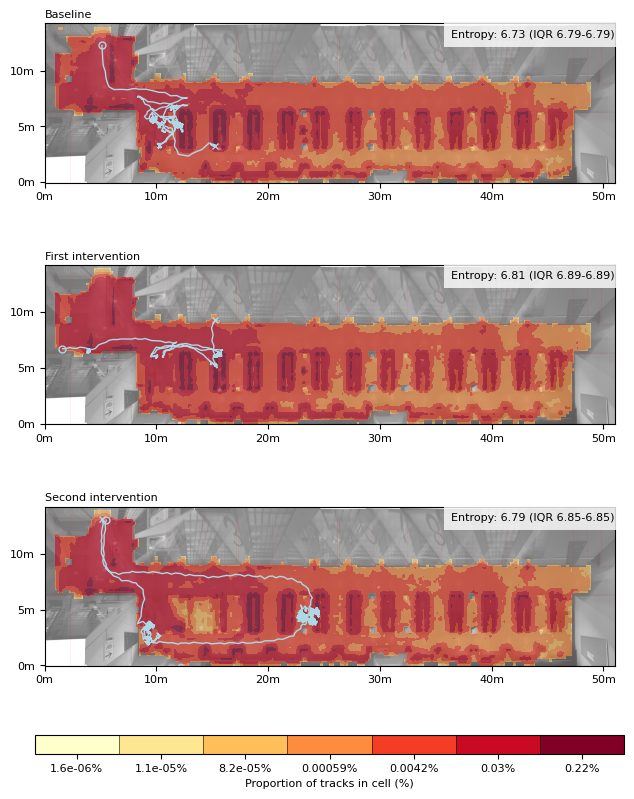

Saved ../results/tracking_spatial_density.png


In [73]:
# colormap
n_col = 7
try:
    from matplotlib import colormaps as mcm
    cmap = mcm.get_cmap('YlOrRd').resampled(n_col)   # Matplotlib ≥ 3.6
except Exception:
    cmap = plt.get_cmap('YlOrRd', n_col)             # works on older versions too

# study phase order
phase_order = ["Baseline", "First intervention", "Second intervention"]
grid_shape = merged_df['counts'].iloc[0].shape

phase_counts, phase_props = {}, {}
for phase in phase_order:
    phase_arrs = merged_df.loc[merged_df['study_phase'] == phase, 'counts'].values
    counts = np.sum(np.stack(phase_arrs), axis=0).astype(np.float32) if len(phase_arrs) else np.zeros(grid_shape, dtype=np.float32)
    total = counts.sum()
    props = counts / total if total > 0 else np.zeros_like(counts, dtype=np.float32)
    phase_counts[phase] = counts
    phase_props[phase] = props

# Global scaling across all panels
positive_vals = [phase_props[p][phase_counts[p] > 0] for p in phase_order if np.any(phase_counts[p] > 0)]
if not positive_vals:
    raise ValueError("No positive counts found in any study phase.")
all_pos = np.concatenate(positive_vals)
vmin, vmax = float(all_pos.min()), float(all_pos.max())

# --- DISCRETE (5-bin) LOG BINS for contrast ---
# 6 edges -> 5 bins
boundaries = np.geomspace(vmin, vmax, n_col + 1)
norm = colors.BoundaryNorm(boundaries, ncolors=cmap.N, clip=False)
# tick locations at bin centers (geometric mean of edges)
bin_centers = np.sqrt(boundaries[:-1] * boundaries[1:])

# --- FIGURE: 3 rows, shared colorbar below all panels ---
plt.rcParams.update({
    'axes.labelsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'axes.titlesize': 8,
    'legend.fontsize': 8,
})

fig, ax_arr = plt.subplots(
    nrows=4, ncols=1,
    figsize=(16/2.54, 20/2.54),
    constrained_layout=True,
    gridspec_kw={'height_ratios': [1, 1, 1, 0.12], 'hspace': 0.25}
)
axes = ax_arr[:3]
cax = ax_arr[3]   # dedicated colorbar axis (empty for now)


track_ids = list(sampled_tracks)[:3]

for ax, phase, track_id in zip(axes, phase_order, track_ids):
    # Background image
    ax.imshow(img, extent=image_extent, aspect='auto')

    # Heatmap (mask zeros)
    counts = phase_counts[phase]
    props = phase_props[phase]
    masked = np.ma.masked_where(counts == 0, props)
    ax.imshow(masked, extent=image_extent, origin='lower', alpha=0.6, cmap=cmap, norm=norm)

    # Axis ticks / labels
    ax.set_xticks([0, 10, 20, 30, 40, 50])
    ax.set_xticklabels(['0m', '10m', '20m', '30m', '40m', '50m'])
    ax.set_yticks([0, 5, 10])
    ax.set_yticklabels(['0m', '5m', '10m'])
    ax.set_xlabel('')
    ax.set_ylabel('')

    # One sampled track per subplot
    track_data = sampled_tracks_df[sampled_tracks_df['track_id'] == track_id]
    ax.plot(track_data['position_x'], track_data['position_y'], color='lightblue', linewidth=1)
    ax.plot(track_data['position_x'].iloc[0], track_data['position_y'].iloc[0],
            'o', color='lightblue', markerfacecolor='none', markersize=5)  # start
    ax.plot(track_data['position_x'].iloc[-1], track_data['position_y'].iloc[-1],
            'x', color='lightblue', markersize=5)  # end

    # Title = study_phase label
    ax.set_title(phase, loc='left', fontsize=8, pad=4)
    
    # Top-right annotation: "Median entropy <value>"
    entropy_text = f"Entropy: {phase_stats.get(phase, '')}"
    ax.text(
        1, .96, entropy_text,
        transform=ax.transAxes,
        ha='right', va='top',
        color='black', fontsize=8,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=5)  # optional for readability
    )

# colobar
n_bins = len(boundaries) - 1  # == n_col
index_boundaries = np.arange(n_bins + 1)              # 0..n_bins (index space)
norm_cb = colors.BoundaryNorm(index_boundaries, ncolors=cmap.N, clip=False)

tick_pos = np.arange(n_bins) + 0.5                    # centers in index space
tick_labels = [f"{(np.sqrt(lo*hi)*100):.2g}%"
               for lo, hi in zip(boundaries[:-1], boundaries[1:])]

cb = ColorbarBase(
    cax, cmap=cmap, norm=norm_cb,
    boundaries=index_boundaries,
    orientation='horizontal',
    spacing='uniform',
    ticks=tick_pos,
    drawedges=True
)

# Force only our ticks/labels; no minors; set explicit range
cb.ax.xaxis.set_major_locator(FixedLocator(tick_pos))
cb.ax.xaxis.set_major_formatter(FixedFormatter(tick_labels))
cb.ax.xaxis.set_minor_locator(NullLocator())
cb.ax.tick_params(labelsize=8, bottom=True, top=False)
cb.ax.set_xlim(0, n_bins)
cb.set_label('Proportion of tracks in cell (%)', fontsize=8)

# Save figure
out_path = '../results/tracking_spatial_density.png'
plt.savefig(out_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved {out_path}")